In [221]:
library(ggplot2)
library(corrplot)
library(vtable)
library(cowplot)
library(moments)
library(Sleuth2)
library(e1071)
library(stringr)
library(car)
library(MASS)
library(sfsmisc)
library(eurostat)
library(report)

## Analýza hrubého domácího produktu evropských zemí v roce 2021.

Nejprve načteme dataset a provedeme výběr dat z roku 2021 dle zadání. <br>
Ponecháme si jen sloupce geo a values. Values dále přejmenujeme na gdp.

In [222]:
df <- get_eurostat("nama_10_pc")

df <- df[df$na_item == "B1GQ", ]
df <- df[df$unit == "CP_EUR_HAB", ]
df <- subset(df, format(as.Date(df$TIME_PERIOD), "%Y") == 2021)
df <- df[-c(1, 1:3)]
df <- df[-c(2)]
colnames(df) <- c("geo", "gdp")

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/11b065fd45a1428b085c6e9d6e760f22.rds

Table  nama_10_pc  read from cache file:  C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/11b065fd45a1428b085c6e9d6e760f22.rds



### Úloha 1

Nejprve prozkoumejme, jaká data náš dataset obsahuje.

In [223]:
head(df, 15)

geo,gdp
<chr>,<dbl>
AL,5390
AT,45270
BE,43850
BG,10330
CH,78990
CY,27690
CZ,22270
DE,43480
DK,58590


Můžeme si povšimnout, že obsahuje údaje nejen o jednotlivých zemích, ale také o různých celcích. <br>
Informace o celku jsou pro nás nepotřebné, proto je zahodíme.

In [224]:
df <- df[df$geo != "EA12", ]
df <- df[df$geo != "EA19", ]
df <- df[df$geo != "EA20", ]
df <- df[df$geo != "EA", ]
df <- df[df$geo != "EU27_2020", ]

In [225]:
df$geo <- as.factor((df$geo))

Pomocí summary získáme přehled o HDP v EU.

In [226]:
summary(df$gdp)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5390   15670   25300   37202   46365  164150 

Dále náš pročištěný dataset zobrazíme.<br>
Nejprve pro celou EU v podobě Box a Violin plotu.<br>

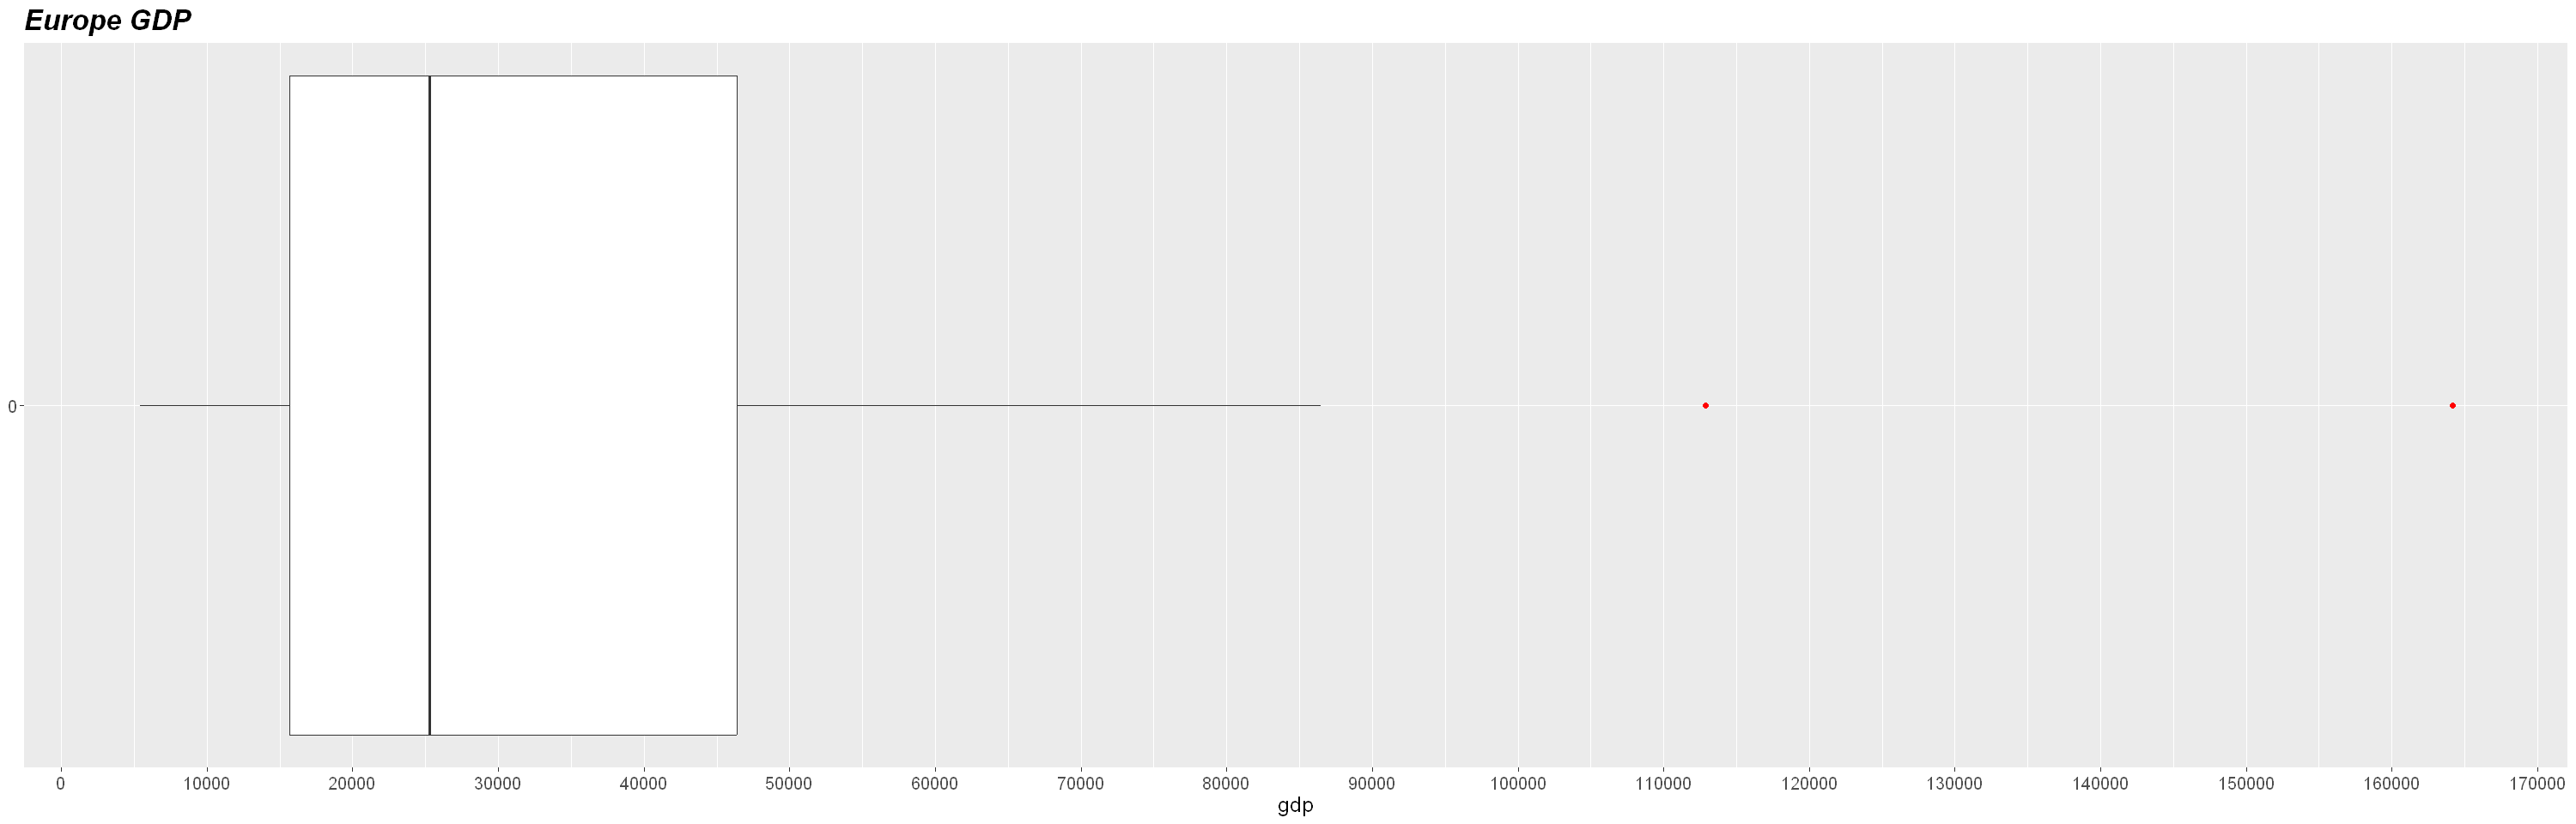

In [227]:
options(width = 70, repr.plot.width = 25, repr.plot.height = 8)

p1 <- ggplot(df, aes(x = gdp)) + scale_x_continuous(breaks = scales::pretty_breaks(n = 15)) + scale_y_continuous(breaks = scales::breaks_pretty(n = 0)) +
  geom_boxplot(outlier.color = "red", show.legend = FALSE) + ggtitle("Europe GDP")

p1 <- p1 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)
)

plot_grid(p1, nrow = 1, rel_widths = 0.5)

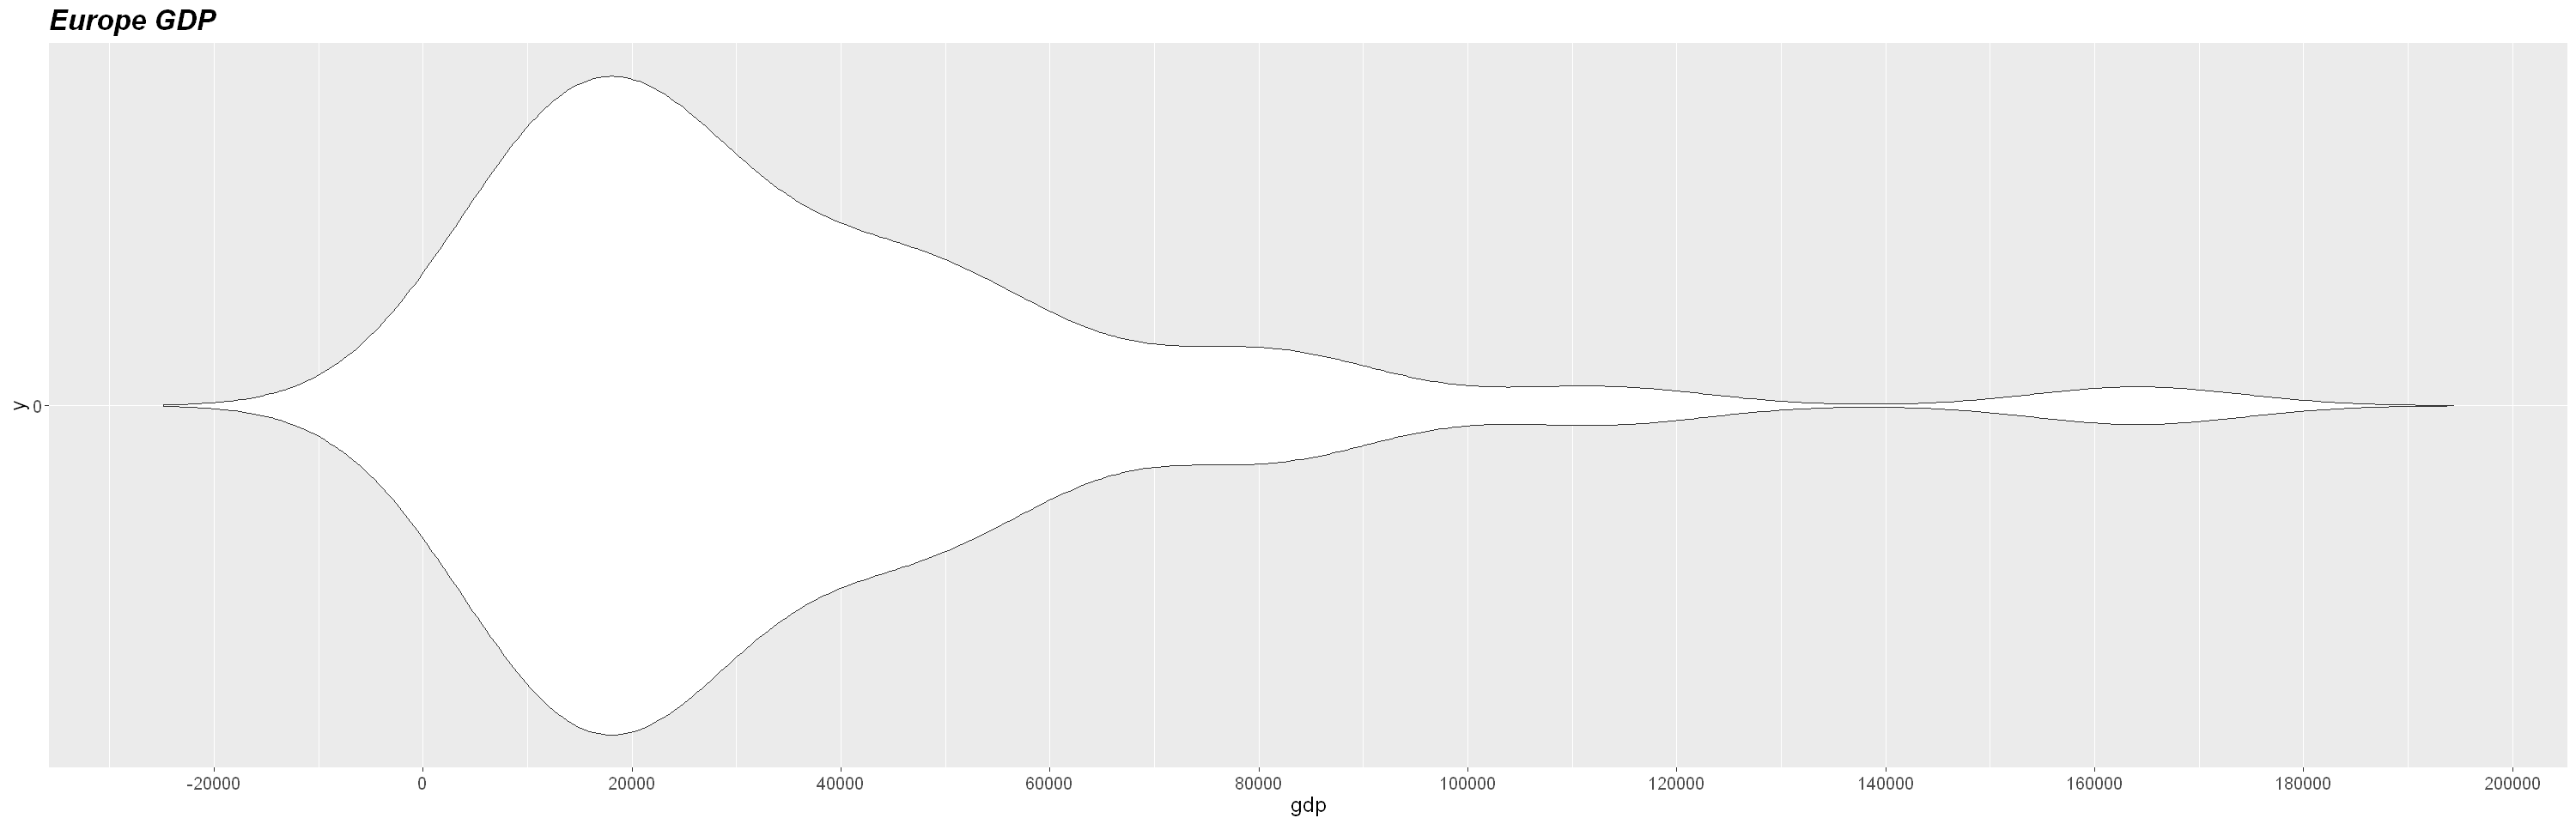

In [228]:
p1 <- ggplot(df, aes(y = 0, x = gdp)) + scale_x_continuous(breaks = scales::pretty_breaks(n = 15)) + scale_y_continuous(breaks = scales::breaks_pretty(n = 0)) +
  geom_violin( show.legend = FALSE, trim = FALSE) + ggtitle("Europe GDP")

p1 <- p1 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)
)

plot_grid(p1, nrow = 1, rel_widths = 0.5)

Dále zobrazíme HDP podle státu.

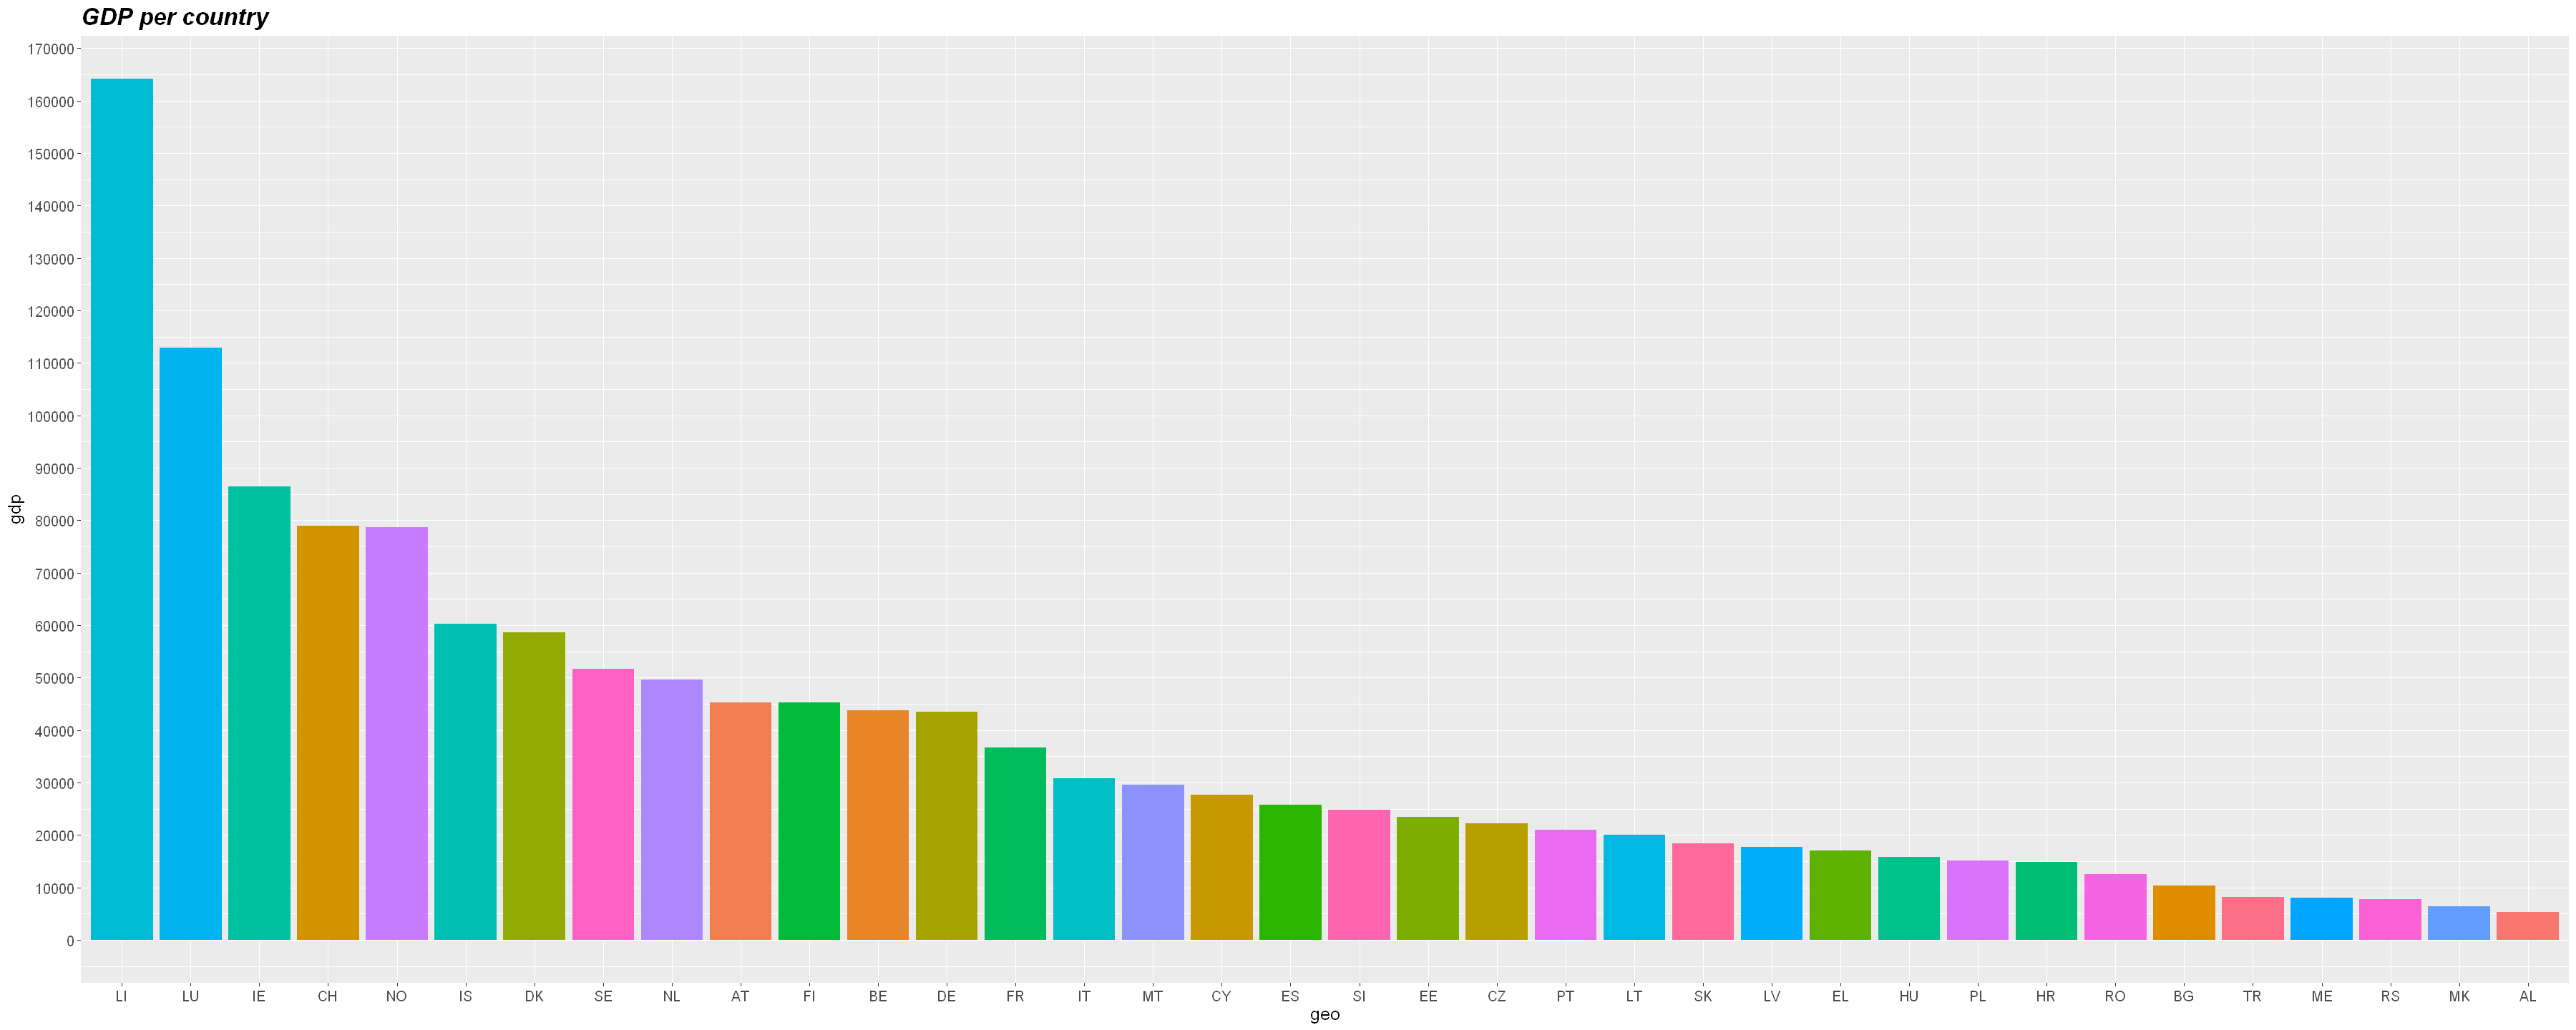

In [229]:
options(width = 80, repr.plot.width = 30, repr.plot.height = 12)

p2 <- ggplot(df, aes(x = reorder(geo,-gdp,sum), y = gdp, fill = geo)) + geom_col() + ggtitle("GDP per country") + scale_y_continuous(breaks = scales::breaks_pretty(n = 15)) + labs(x = "geo")

p2 <- p2 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)

)

pg <- plot_grid(p2 + theme(legend.position = "none"),
                nrow = 1)

plot_grid(pg, rel_widths = c(2, .2))

### Úloha 2

Jako údaje, které podle nás mohou s HDP souviset jsme vybrali tyto: <br>
věk, politické zřízení, využití internetu a R&D (množství prostředků, které jsou v dané zemi vynaloženy na vývoj) <br>
Dále tyto údaje získáme.

#### Dataframe o věku

Pro zpracování tohoto datasetu volíme postup téměř analogický s přípravou datasetu předchozího.

In [230]:
dfAge <- get_eurostat("hlth_hlye")

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/4081099d4993281420610b0645bac26e.rds

Table  hlth_hlye  read from cache file:  C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/4081099d4993281420610b0645bac26e.rds



Vybíráme hodnoty pro rok 2021, které vystihují předpoklad dožití nezávisle na pohlaví.

In [231]:
dfAge <- subset(dfAge, format(as.Date(dfAge$TIME_PERIOD), "%Y") == 2021)
dfAge <- dfAge[dfAge$unit == "YR", ]
dfAge <- dfAge[dfAge$sex == "T", ]
dfAge <- dfAge[dfAge$indic_he == "LE_0", ]

In [232]:
dfAge$geo <- as.factor((dfAge$geo))

dfAge <- dfAge[-c(1,1:4)]
dfAge <- dfAge[-c(2)]

colnames(dfAge) <- c("geo", "life_expectancy")
temp <- merge(df, dfAge, by = "geo")

Získané informace vizualizujeme podle země.

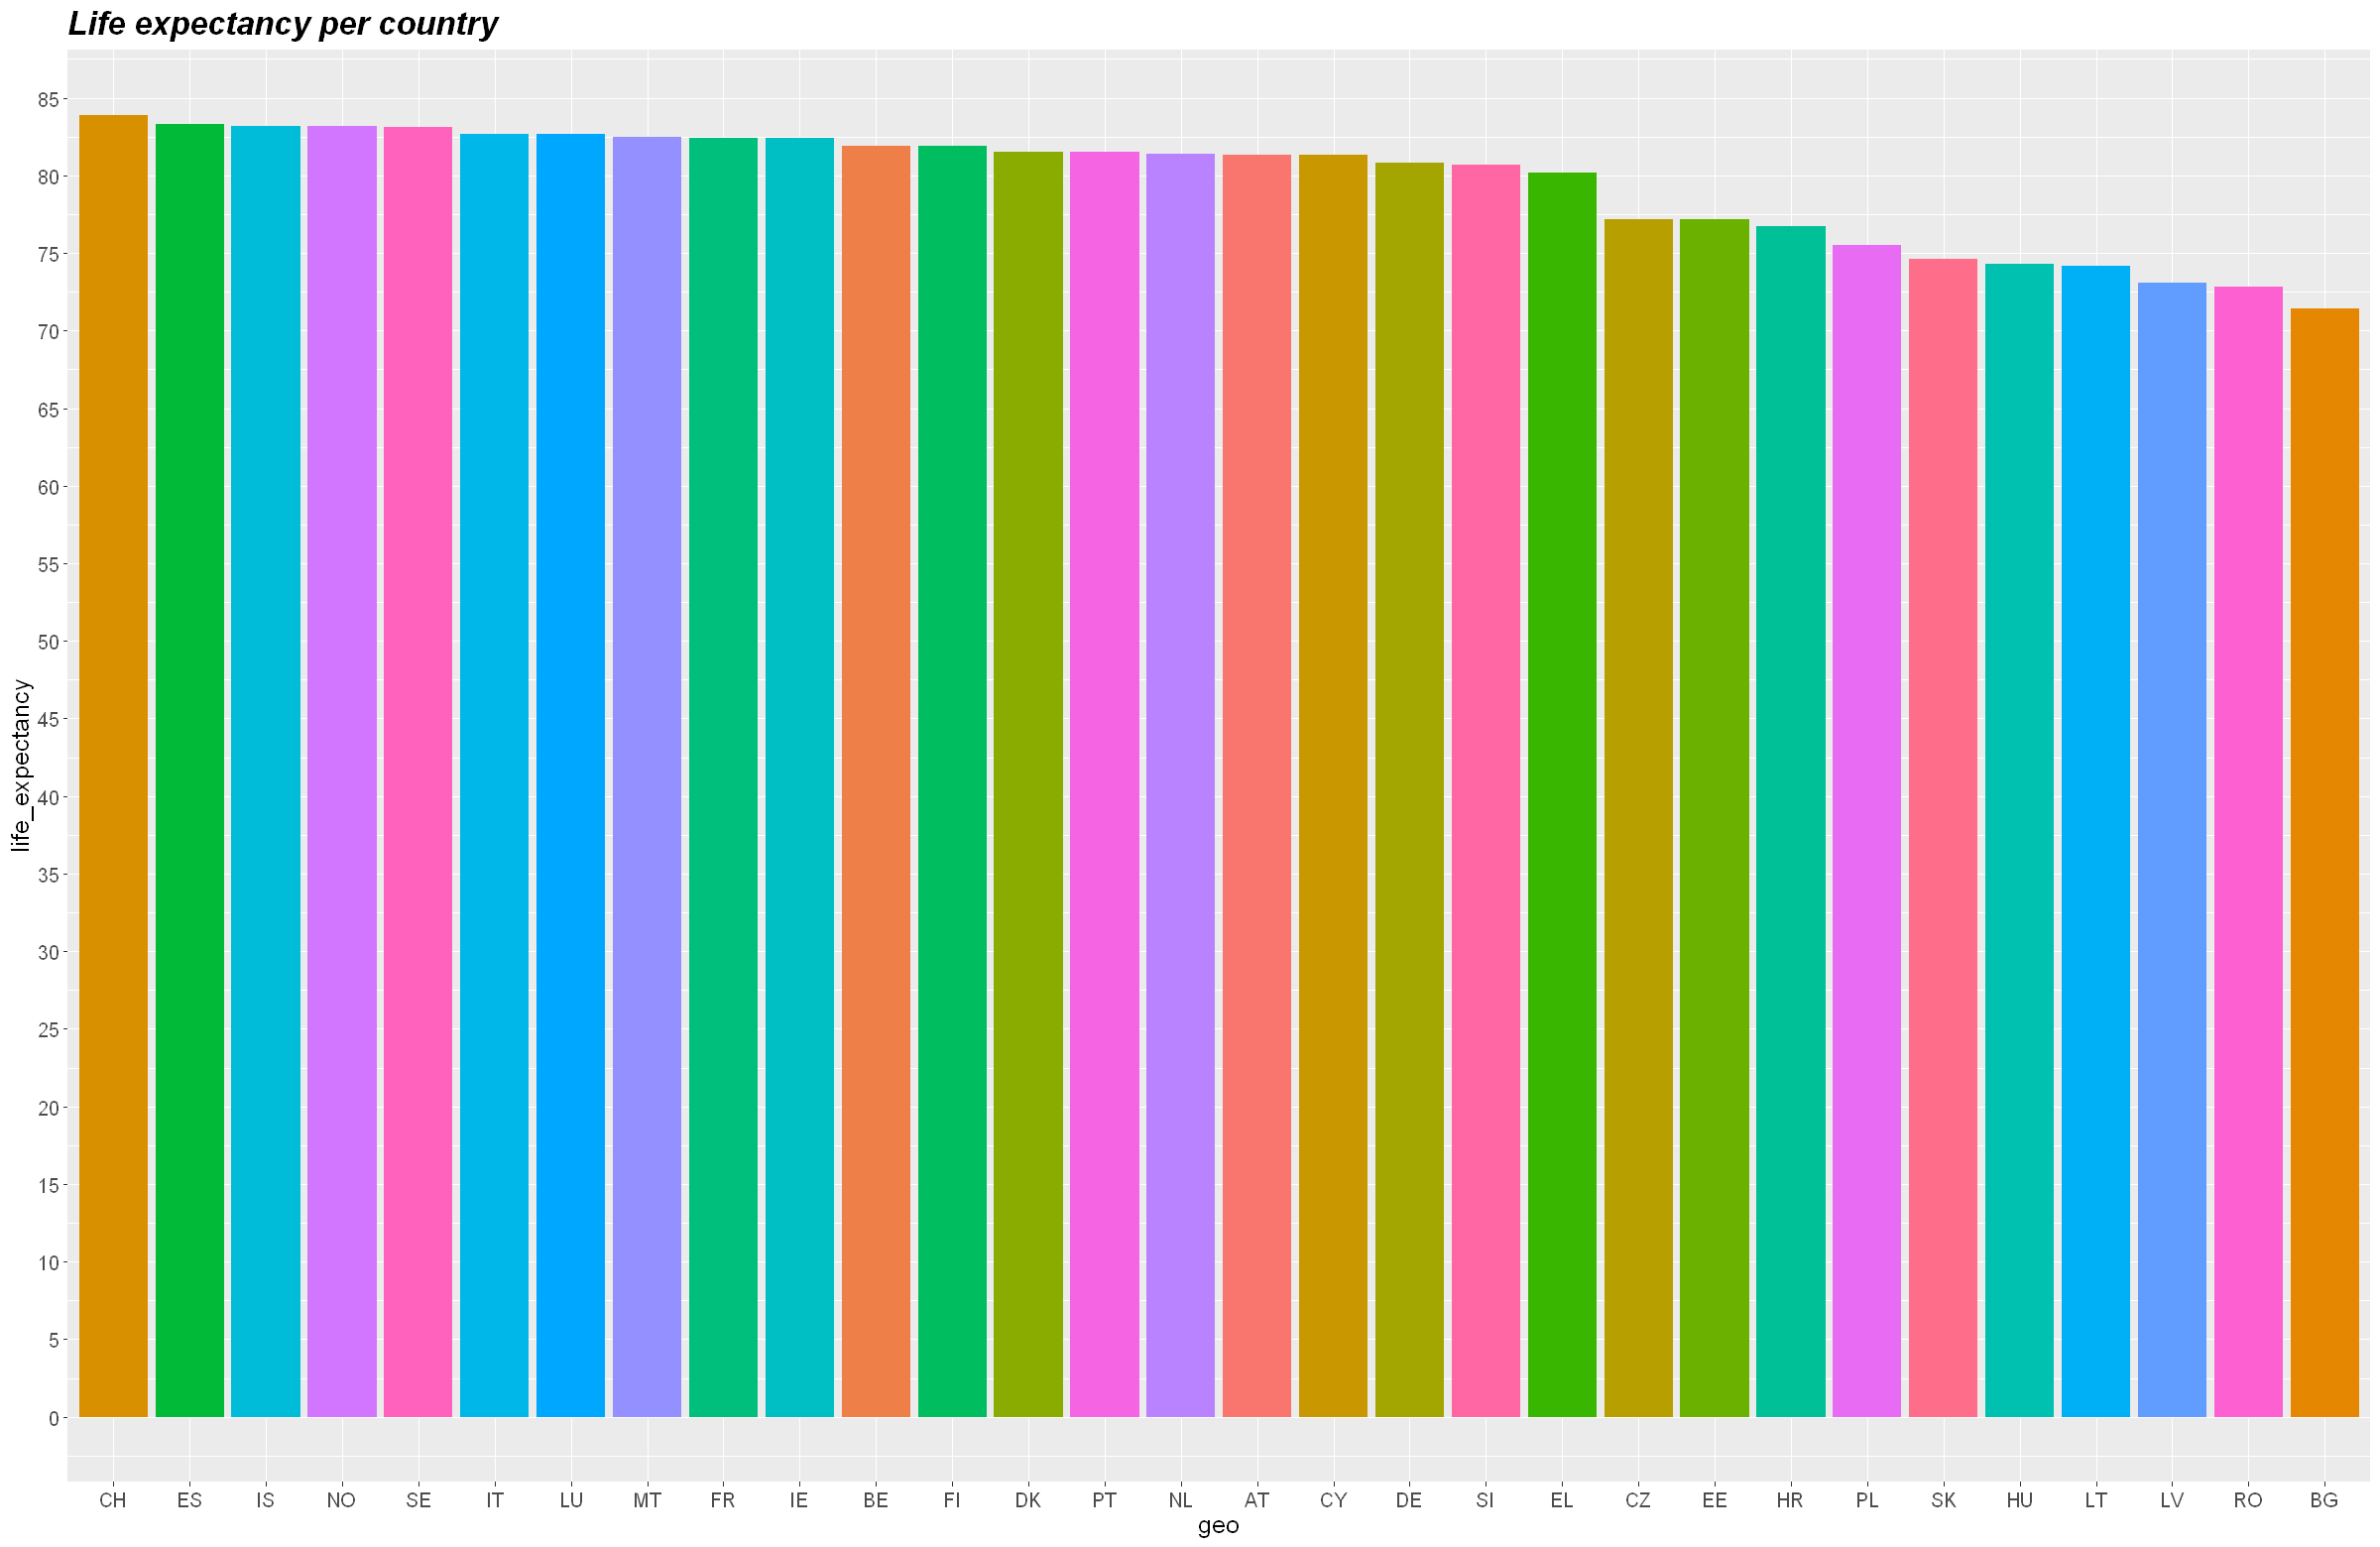

In [233]:
options(repr.plot.width = 20, repr.plot.height = 13)

p2 <- ggplot(temp, aes(x = reorder(geo,-life_expectancy,sum), y = life_expectancy, fill = geo)) + geom_col() + ggtitle("Life expectancy per country") + scale_y_continuous(breaks = scales::breaks_pretty(n = 15)) + labs(x = "geo")

p2 <- p2 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)

)

pg <- plot_grid(p2 + theme(legend.position = "none"),
                nrow = 1)

plot_grid(pg, rel_widths = c(2, .2))

Otestujeme, jaká je lineární závislost mezi HDP a LE. Položíme:<br>
**H0:** Koeficient LE je roven 0<br>
**HA:** Koeficient LE je nenulový

In [234]:
res <- lm(gdp ~ life_expectancy, data = temp)
summary(res)


Call:
lm(formula = gdp ~ life_expectancy, data = temp)

Residuals:
   Min     1Q Median     3Q    Max 
-28256 -12647   -752   6523  61433 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -310927.2    75458.0  -4.121 0.000304 ***
life_expectancy    4381.6      946.6   4.629 7.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 19360 on 28 degrees of freedom
Multiple R-squared:  0.4335,	Adjusted R-squared:  0.4133 
F-statistic: 21.43 on 1 and 28 DF,  p-value: 7.646e-05


Zamítáme H0 ve prospěch HA.<br>
Předpokládáme tedy, že LE bude s HDP souviset.

#### Dataframe o politickém systému

Dále získáme data o politickém zřízení.

In [235]:
dfPoliticalSystem <- read.csv("systems.csv")

In [236]:
dfPoliticalSystem$geo <- as.factor((dfPoliticalSystem$geo))

dfPoliticalSystem <- dfPoliticalSystem[-c(2)]

In [237]:
dfPoliticalSystem$system <- as.factor(dfPoliticalSystem$system)
dfPoliticalSystem$geo <- as.factor(dfPoliticalSystem$geo)
temp <- merge(df, dfPoliticalSystem, by = "geo")


Po provedení počátečních úprav získáváme dataset, který má následující podobu:

In [238]:
head(dfPoliticalSystem)

,geo,system
,<fct>,<fct>
1,AL,Republic
2,AD,Monarchy
3,AM,Republic
4,AT,Republic
5,BY,Republic
6,BE,Monarchy


Celkový výčet politických zřízení dále vizualizujeme.

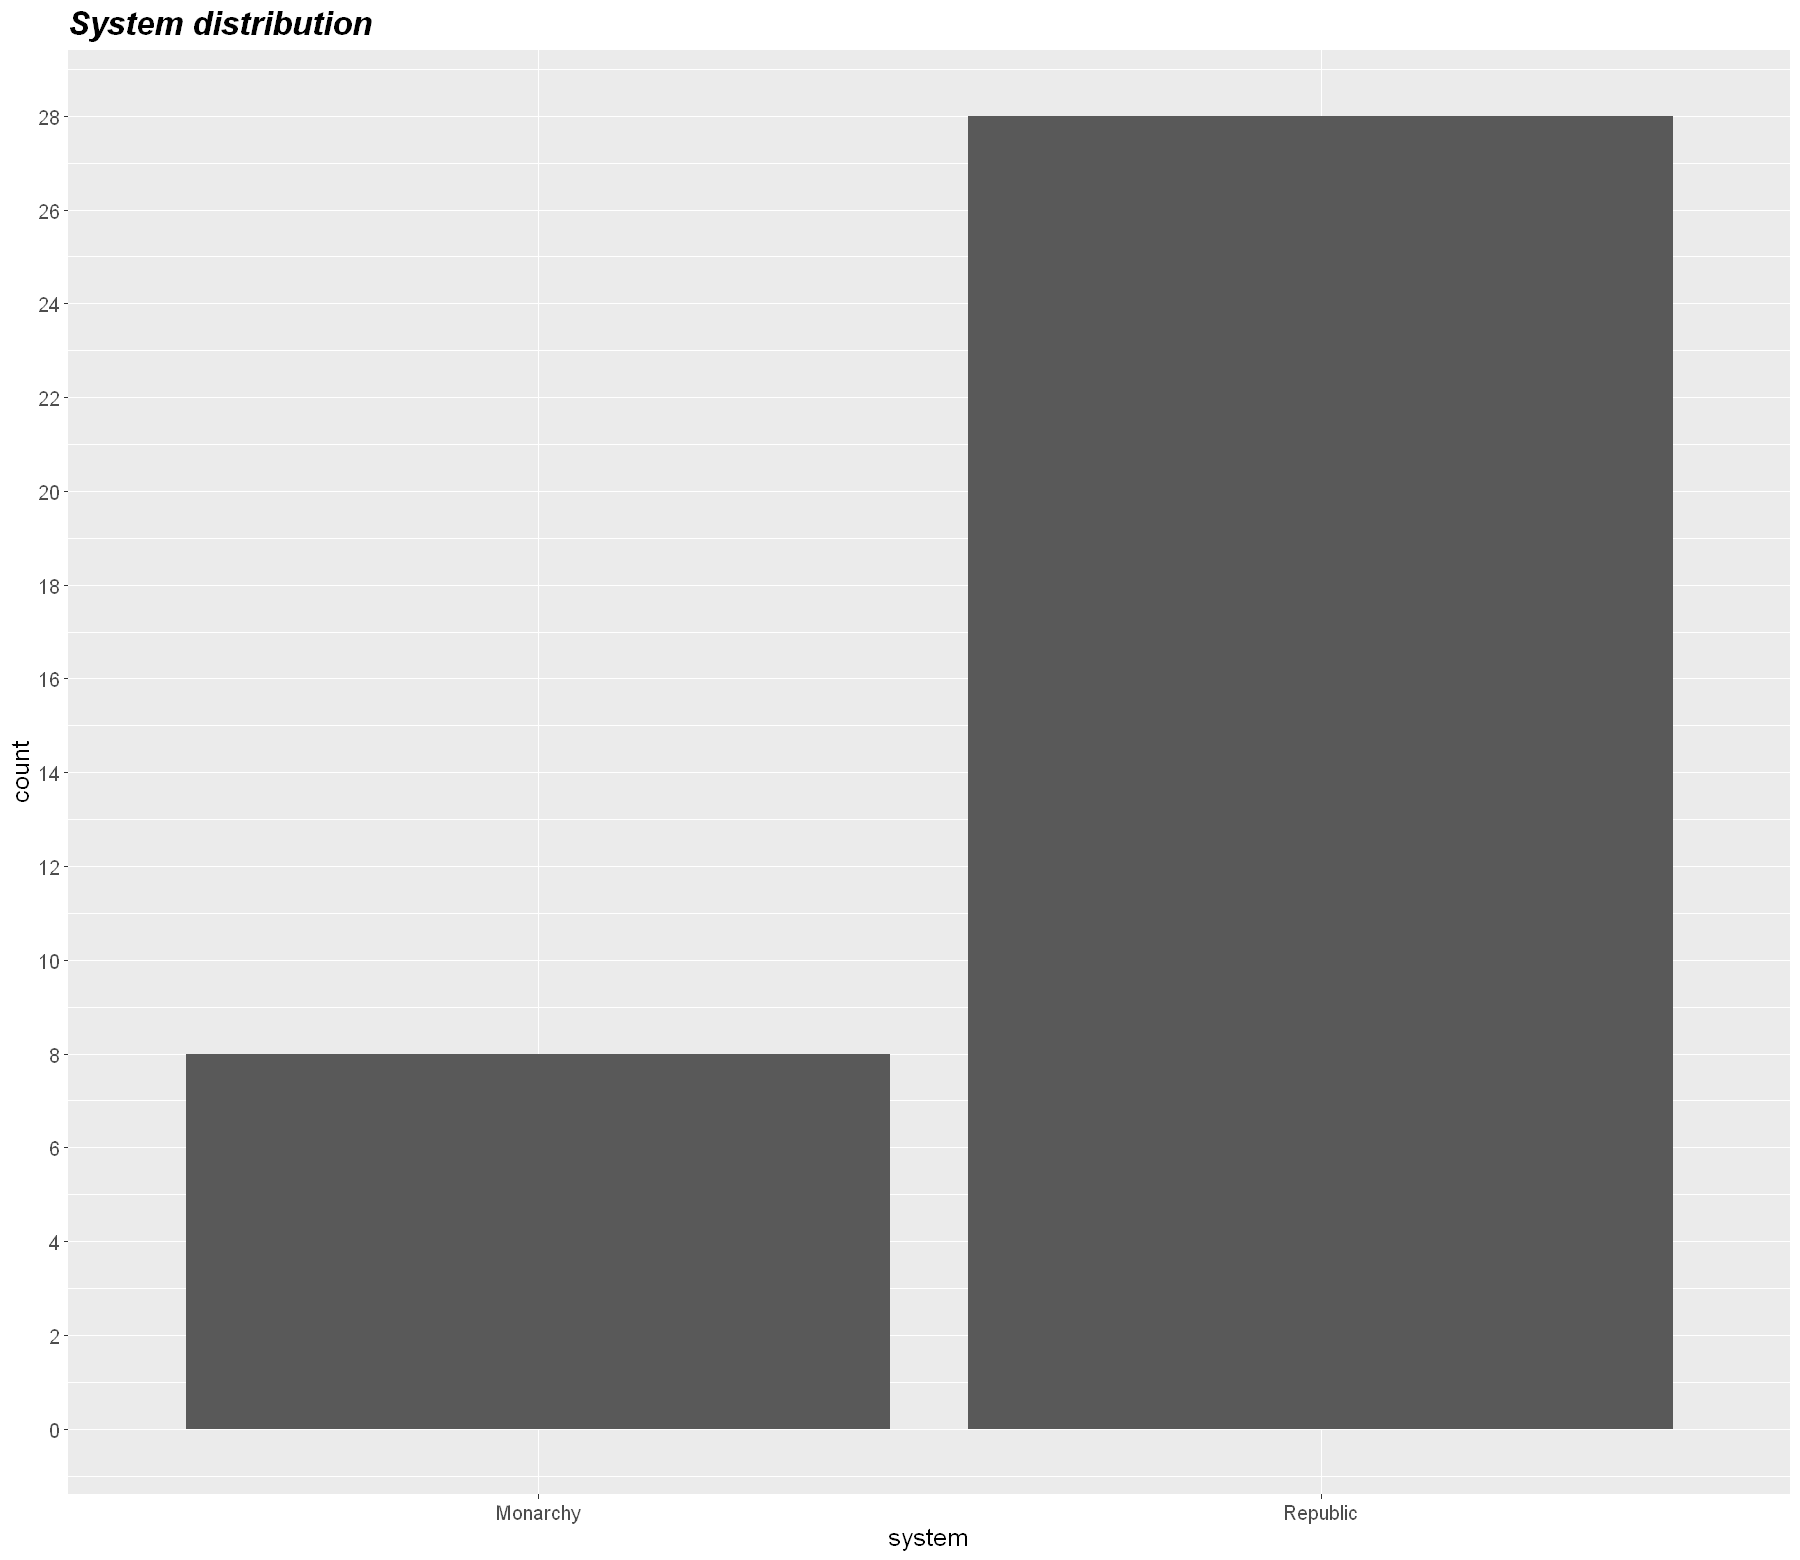

In [239]:
options(repr.plot.width = 15, repr.plot.height = 13)

p2 <- ggplot(temp, aes(x = system)) + geom_bar() + ggtitle("System distribution") + scale_y_continuous(breaks = scales::breaks_pretty(n = 15)) 

p2 <- p2 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)

)

pg <- plot_grid(p2 + theme(legend.position = "none"),
                nrow = 1)

plot_grid(pg, rel_widths = c(2, .2))

Dále provedeme test anova, neboli analýzu roztpylu podle skupin. Položíme:<br>
**H0:** Střední hodnoty HDP jsou u všech kategorií stejné<br>
**HA:** Střední hodnoty HDP se neshodují

In [240]:
res_aov <- aov(gdp ~ system, data = temp)
print(report(res_aov))

The ANOVA (formula: gdp ~ system) suggests that:

  - The main effect of system is statistically significant and large (F(1, 34) =
17.48, p < .001; Eta2 = 0.34, 95% CI [0.14, 1.00])

Effect sizes were labelled following Field's (2013) recommendations.


Vzhledem k p-hodnotě se přikláníme k alternativě. <br>
Střední hodnoty u jednotlivých kategorií jsou tedy významně různé, tím pádem politické zřízení může mít na HDP vliv.

#### Dataframe o využíváni Internetu

Analogicky k datasetu z úlohy 1 připravíme i dataset o využívání internetu...

In [241]:
dfInternet <- get_eurostat("isoc_ci_ifp_iu")

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/7db07f15e82a1490a0056538c20a81eb.rds

Table  isoc_ci_ifp_iu  read from cache file:  C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/7db07f15e82a1490a0056538c20a81eb.rds



Procento ze všech občanů, který v posledních 3 měsících využili internet.

In [242]:
dfInternet <- subset(dfInternet, format(as.Date(dfInternet$TIME_PERIOD), "%Y") == 2021)
dfInternet <- dfInternet[dfInternet$indic_is == "I_IU3", ]
dfInternet <- dfInternet[dfInternet$unit == "PC_IND", ]
dfInternet <- dfInternet[dfInternet$ind_type == "IND_TOTAL", ]

In [243]:
dfInternet$geo <- as.factor((dfInternet$geo))

dfInternet <- dfInternet[-c(1:4)]
dfInternet <- dfInternet[-c(2)]

colnames(dfInternet) <- c("geo", "internet_usage")
temp <- merge(df, dfInternet, by = "geo")

Získáme přehled a vizualizujeme...

In [244]:
summary(dfInternet$internet_usage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  75.27   82.63   89.00   88.93   93.62   99.44 

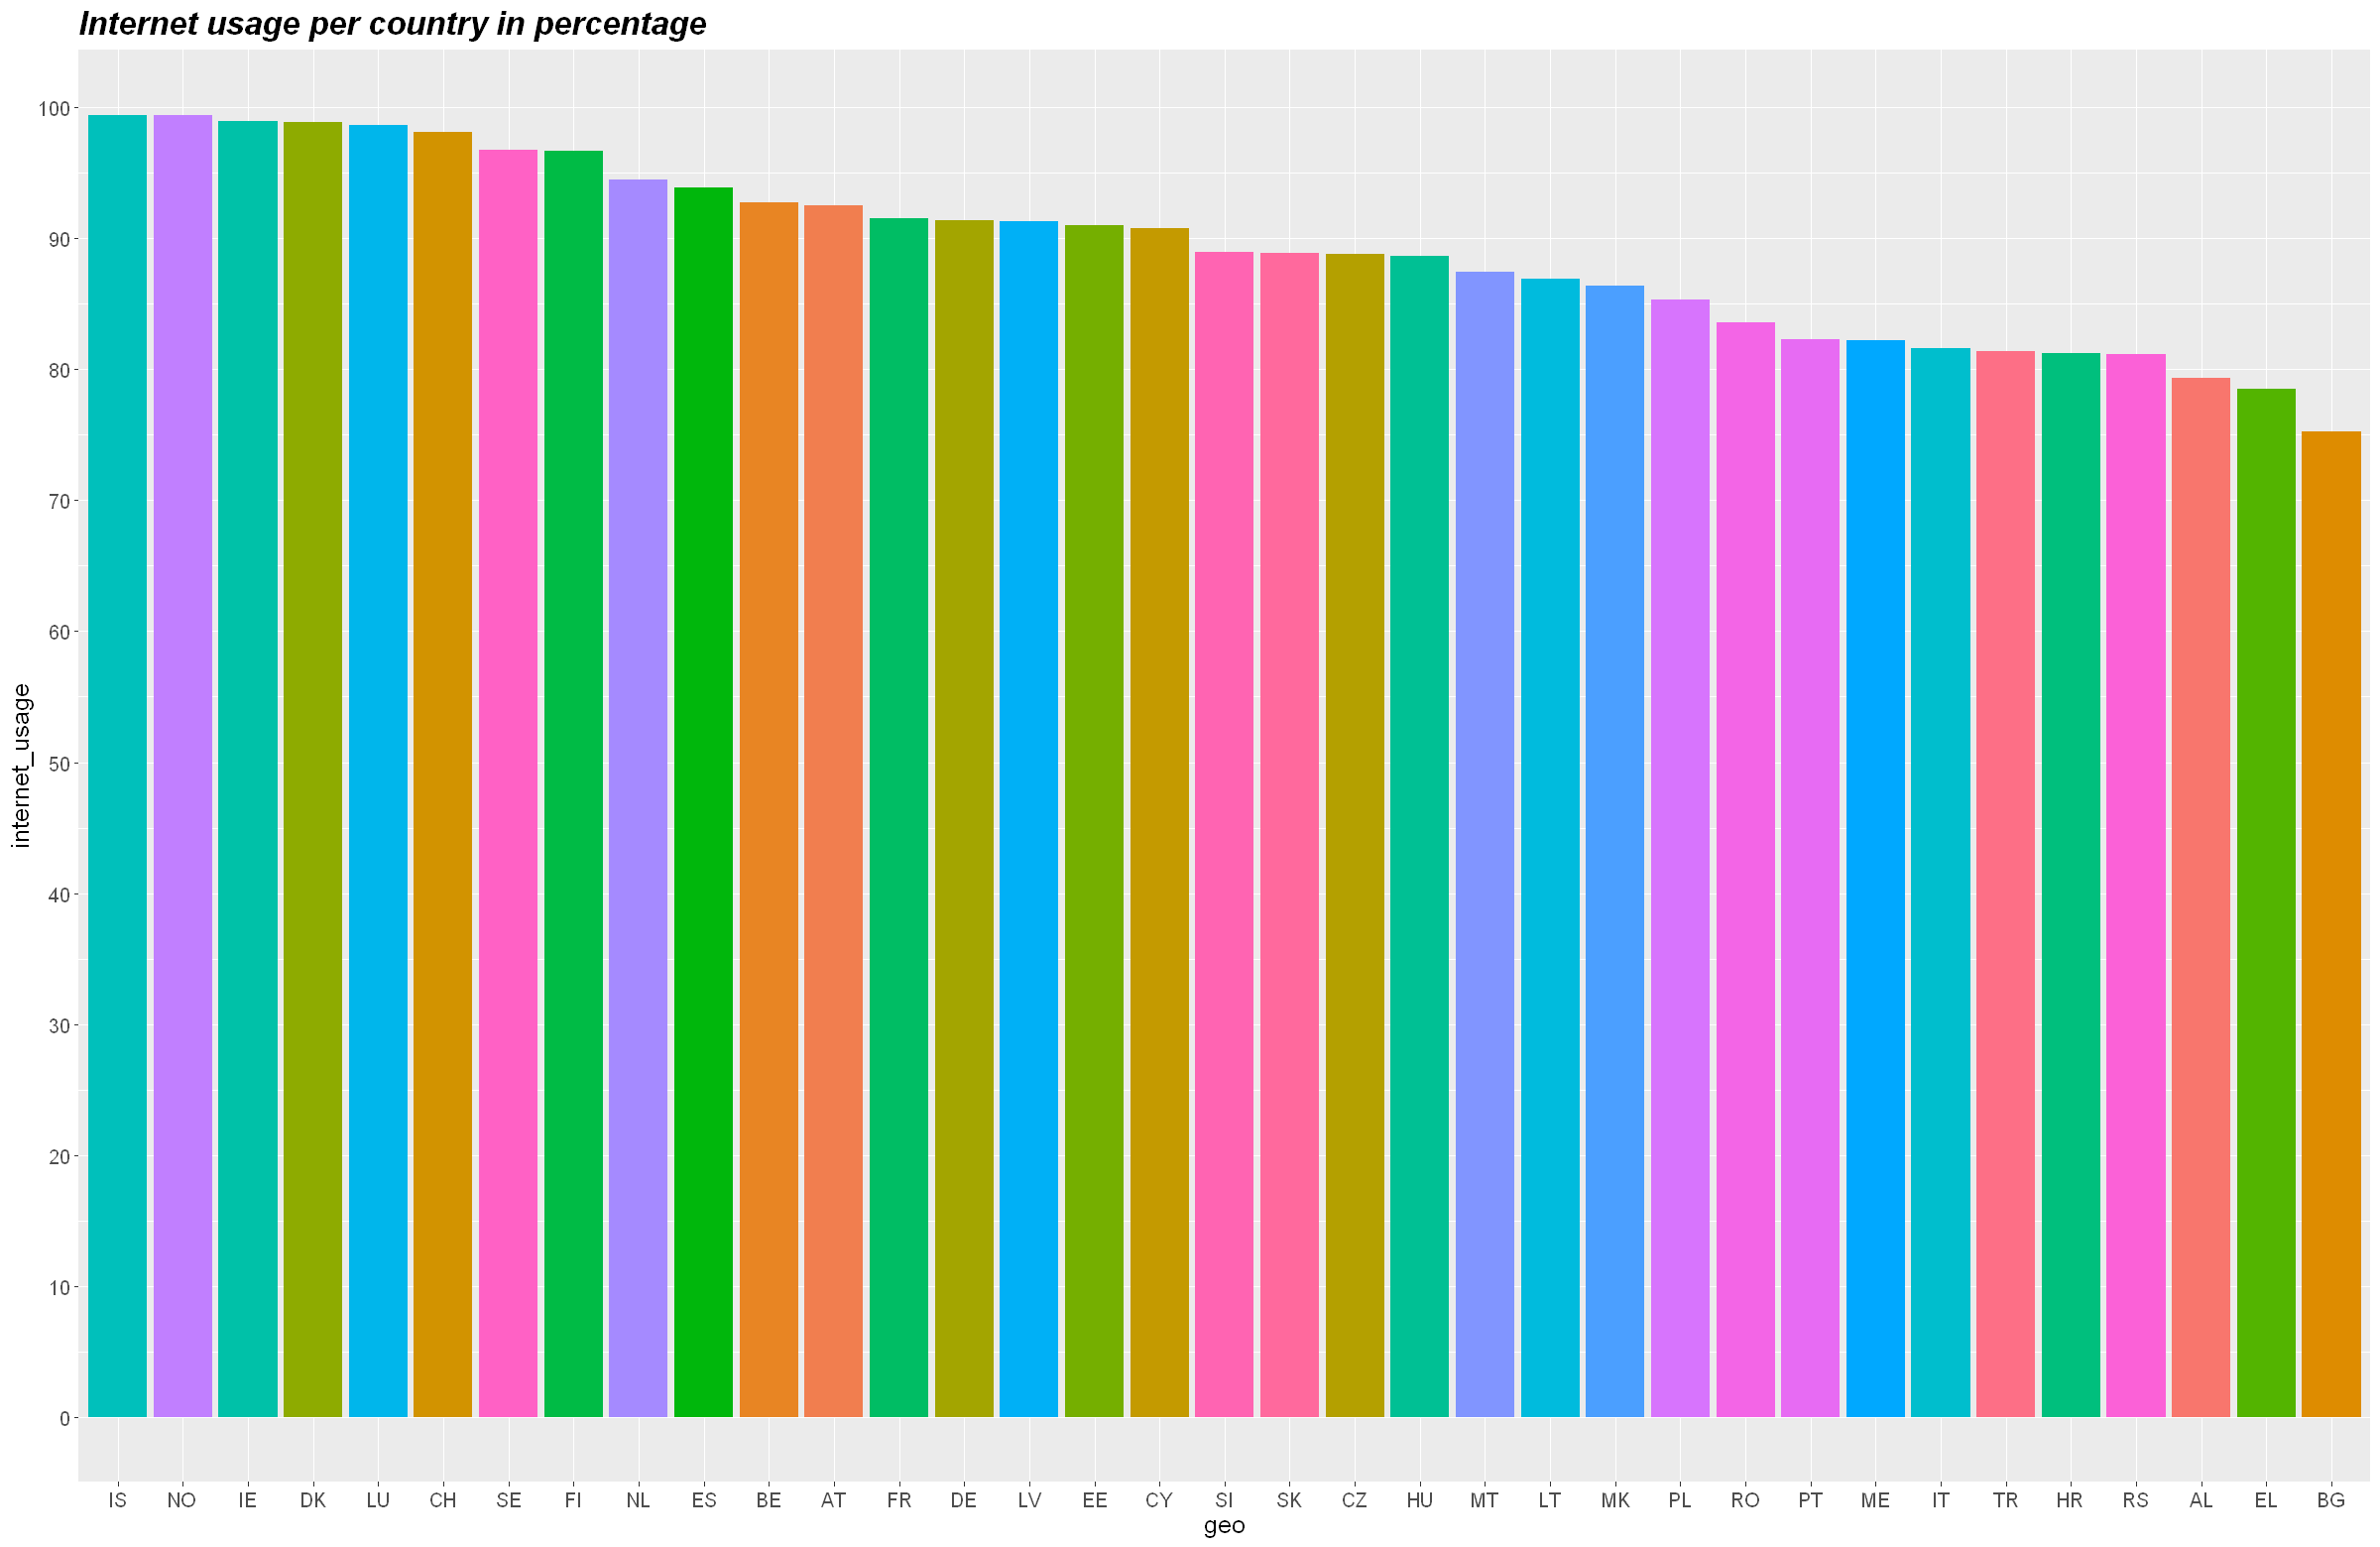

In [245]:
options(repr.plot.width = 20, repr.plot.height = 13)

p2 <- ggplot(temp, aes(x = reorder(geo,-internet_usage,sum), y = internet_usage, fill = geo)) + geom_col() + ggtitle("Internet usage per country in percentage") + scale_y_continuous(breaks = scales::breaks_pretty(n = 15)) + labs(x = "geo")

p2 <- p2 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)

)

pg <- plot_grid(p2 + theme(legend.position = "none"),
                nrow = 1)

plot_grid(pg, rel_widths = c(2, .2))

Ověříme lineární závislost HDP na využití internetu. Položíme:<br>
**H0:** Koeficient využití je roven 0<br>
**HA:** Koeficient využití je nenulový

In [246]:
res <- lm(gdp ~ internet_usage, data = temp)
summary(res)


Call:
lm(formula = gdp ~ internet_usage, data = temp)

Residuals:
   Min     1Q Median     3Q    Max 
-22097  -8927  -3332   4713  50290 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -242557.8    33720.8  -7.193 3.03e-08 ***
internet_usage    3092.7      376.6   8.212 1.75e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15000 on 33 degrees of freedom
Multiple R-squared:  0.6714,	Adjusted R-squared:  0.6615 
F-statistic: 67.44 on 1 and 33 DF,  p-value: 1.755e-09


Zamítáme H0 ve prospěch HA.<br>
Očekáváme tedy, že mezi využitím internetu a HDP je nějaký vztah.

#### Dataframe na výdaje na různé sektory

Postup je opět analogický...

In [247]:
dfSectors <- get_eurostat("tsc00001")

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/5c4be52426ca58a707e4e3dd005f9058.rds

Table  tsc00001  read from cache file:  C:\Users\lukas\AppData\Local\Temp\RtmpUF0vQm/eurostat/5c4be52426ca58a707e4e3dd005f9058.rds



In [248]:
dfSectors <- subset(dfSectors, format(as.Date(dfSectors$TIME_PERIOD), "%Y") == 2021)
dfSectors <- dfSectors[dfSectors$sectperf == "TOTAL", ]

In [249]:
dfSectors$geo <- as.factor((dfSectors$geo))

dfSectors <- dfSectors[-c(1,1:3)]
dfSectors <- dfSectors[-c(2)]
colnames(dfSectors) <- c("geo", "sectors_expenditure")
temp <- merge(df, dfSectors, by = "geo")


In [250]:
summary(dfSectors$sectors_expenditure)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.190   1.105   1.770   1.961   2.780   4.930 

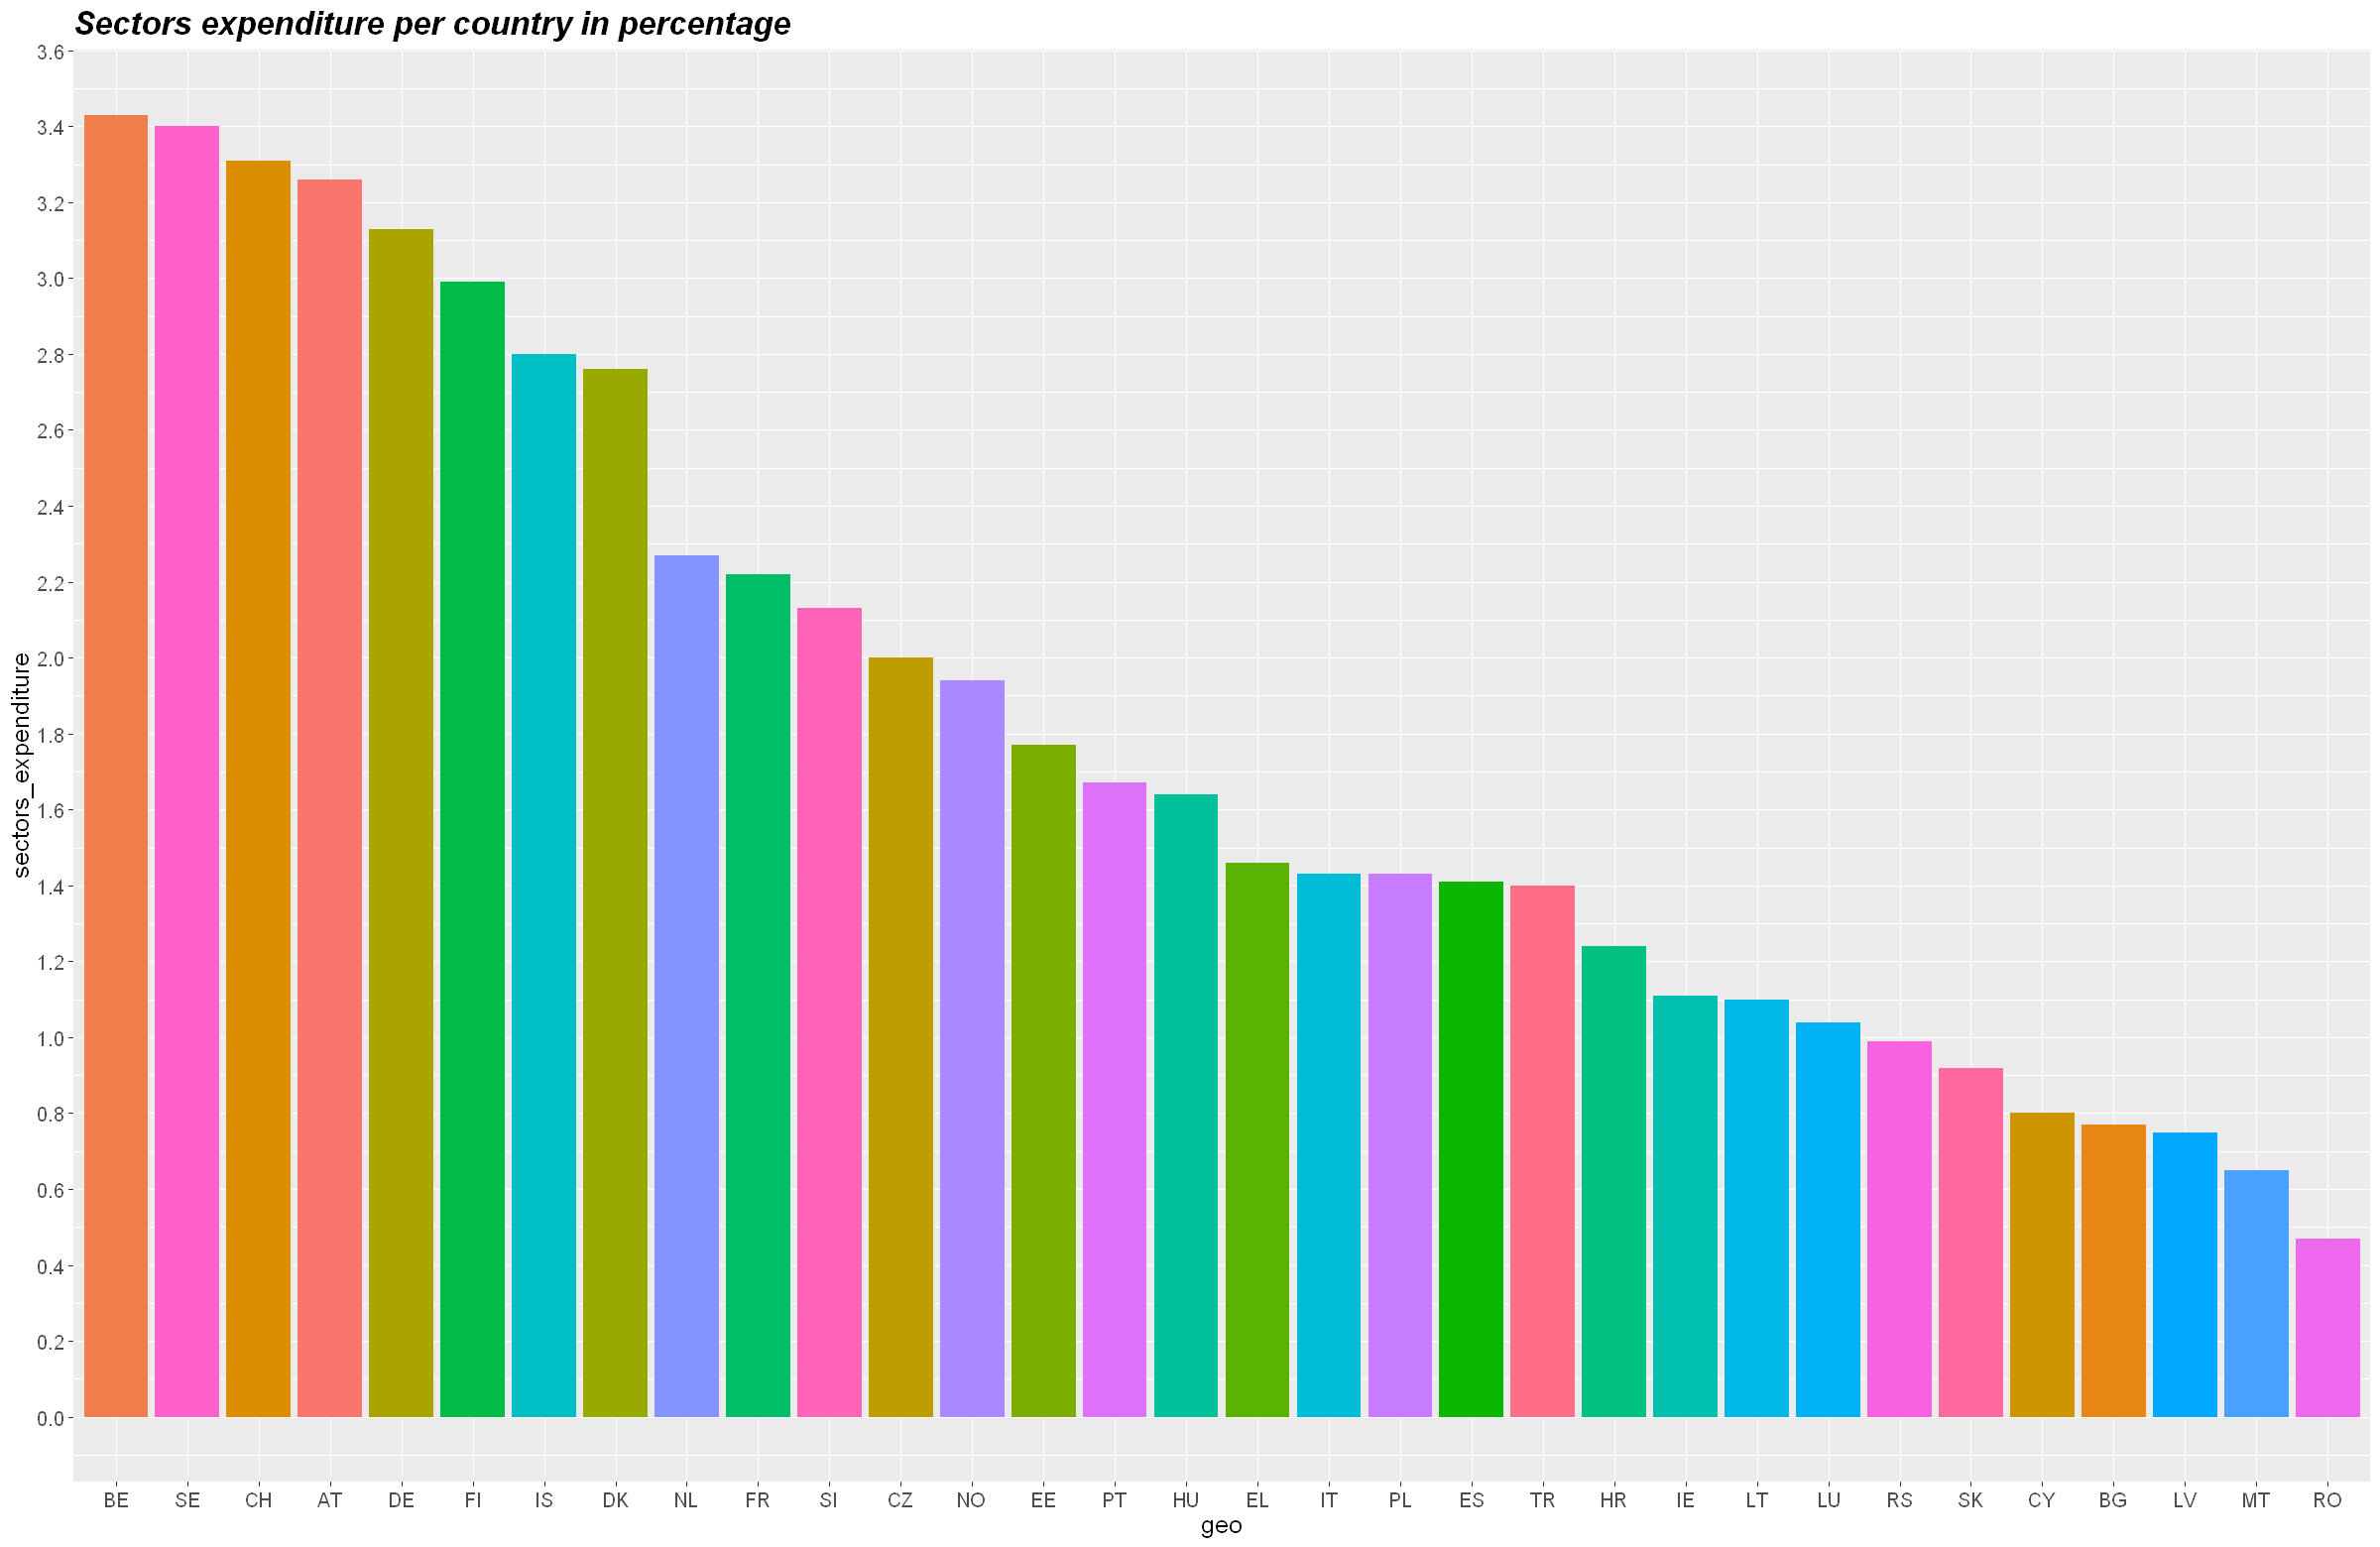

In [251]:
options(repr.plot.width = 20, repr.plot.height = 13)

p2 <- ggplot(temp, aes(x = reorder(geo,-sectors_expenditure,sum), y = sectors_expenditure, fill = geo)) + geom_col() + ggtitle("Sectors expenditure per country in percentage") + scale_y_continuous(breaks = scales::breaks_pretty(n = 15)) + labs(x = "geo")

p2 <- p2 + theme( 
  plot.title = element_text(color="black", size=20, face="bold.italic"),
  text = element_text(size = 15)

)

pg <- plot_grid(p2 + theme(legend.position = "none"),
                nrow = 1)

plot_grid(pg, rel_widths = c(2, .2))

Otestujeme, jaká je lineární závislost mezi HDP a R&D. Položíme:<br>
**H0:** Koeficient R&D je roven 0<br>
**HA:** Koeficient R&D je nenulový

In [252]:
res <- lm(gdp ~ sectors_expenditure, data = temp)
summary(res)


Call:
lm(formula = gdp ~ sectors_expenditure, data = temp)

Residuals:
   Min     1Q Median     3Q    Max 
-23390 -14380  -7326   3718  85304 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)            15904       9468   1.680   0.1034  
sectors_expenditure    11204       4705   2.381   0.0238 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 23800 on 30 degrees of freedom
Multiple R-squared:  0.159,	Adjusted R-squared:  0.1309 
F-statistic: 5.671 on 1 and 30 DF,  p-value: 0.02379


Zamítáme H0 ve prospěch HA.<br>
Očekáváme tedy, že mezi R&D a HDP je nějaký vztah.

#### Spojení dataframů do df

Pro účely zkoumání závislostí mezi regresory je spojíme do jednoho datasetu.<br>
Před tím také převedeme politické zřízení na číselné hodnoty.

In [253]:
dfPoliticalSystem$system <- ifelse(dfPoliticalSystem$system == "Republic", 1, 0)

In [254]:
df <- merge(dfAge, df, by = "geo")
df <- merge(dfPoliticalSystem, df, by = "geo")
df <- merge(dfInternet, df, by = "geo")
df <- merge(dfSectors, df, by = "geo")

In [255]:
head(df, 10)

,geo,sectors_expenditure,internet_usage,system,life_expectancy,gdp
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AT,3.26,92.53,1,81.3,45270
2,BE,3.43,92.79,0,81.9,43850
3,BG,0.77,75.27,1,71.4,10330
4,CH,3.31,98.14,1,83.9,78990
5,CY,0.80,90.76,1,81.3,27690
6,CZ,2.00,88.85,1,77.2,22270
7,DE,3.13,91.43,1,80.8,43480
8,DK,2.76,98.89,0,81.5,58590
9,EE,1.77,90.98,1,77.2,23430


#### Zkoumání závislosti mezi regresory

##### Numerická x Numerická

Na všechna porovnání *Num x Num* využijeme spearmanův test. Položíme tedy:<br>
**H0:** Korelační koeficient je roven 0<br>
**HA:** Korelační koeficient je nenulový

Spearmanův test jsme zvolili, neboť jeho užitím jsme se zbavili nutnosti ověřovat normalitu.

In [256]:
cor.test(df$internet_usage, df$life_expectancy, method='spearman')

Warning message in cor.test.default(df$internet_usage, df$life_expectancy, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  df$internet_usage and df$life_expectancy
S = 1508.7, p-value = 6.236e-05
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6643662 


Vzhledem k p-hodnotě se přikláníme k alternativě.

In [257]:
cor.test(df$internet_usage, df$sectors_expenditure, method='spearman')

Warning message in cor.test.default(df$internet_usage, df$sectors_expenditure, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  df$internet_usage and df$sectors_expenditure
S = 2214.7, p-value = 0.00422
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5072867 


Vzhledem k p-hodnotě se přikláníme k alternativě.

In [258]:
cor.test(df$life_expectancy, df$sectors_expenditure, method='spearman')

Warning message in cor.test.default(df$life_expectancy, df$sectors_expenditure, :
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  df$life_expectancy and df$sectors_expenditure
S = 2493.7, p-value = 0.01368
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4452239 


Vzhledem k p-hodnotě se přikláníme k alternativě.<br>
Z testů zároveň můžeme vyčíst odhady korelace. Korelace jsou ve všech případech pozitivní, nejvíce korelované jsou využití internetu a předpokládané dožití, nejméně pak dožití a R&D.

##### Numerická x Kategorická

Na porovnání *Num x Kat* využijeme dříve zmíněný anova test. Položíme:<br>
**H0:** Střední hodnoty jsou u všech kategorií stejné<br>
**HA:** Střední hodnoty se neshodují

In [259]:
res_aov <- aov(internet_usage ~ system, data = df)
print(report(res_aov))

The ANOVA (formula: internet_usage ~ system) suggests that:

  - The main effect of system is statistically significant and large (F(1, 28) =
9.63, p = 0.004; Eta2 = 0.26, 95% CI [0.06, 1.00])

Effect sizes were labelled following Field's (2013) recommendations.


Vzhledem k p-hodnotě se přikláníme k alternativě.<br>
Politické zřízení tak může ovlivnit využití internetu.

In [260]:
res_aov <- aov(life_expectancy ~ system, data = df)
print(report(res_aov))

The ANOVA (formula: life_expectancy ~ system) suggests that:

  - The main effect of system is statistically significant and large (F(1, 28) =
5.85, p = 0.022; Eta2 = 0.17, 95% CI [0.01, 1.00])

Effect sizes were labelled following Field's (2013) recommendations.


Vzhledem k p-hodnotě se přikláníme k alternativě.<br>
Politické zřízení tak může mít vliv na očekávané dožití.

In [261]:
res_aov <- aov(sectors_expenditure ~ system, data = df)
print(report(res_aov))

The ANOVA (formula: sectors_expenditure ~ system) suggests that:

  - The main effect of system is statistically not significant and medium (F(1,
28) = 2.58, p = 0.119; Eta2 = 0.08, 95% CI [0.00, 1.00])

Effect sizes were labelled following Field's (2013) recommendations.


Vzhledem k p-hodnotě nezamítáme nulovou hypotézu.<br>
Střední hodnoty nejsou významně různé, tím pádem R&D nemusí s politickým zřízením souviset.

### Úloha 3

Vytvoříme jednoduchý regresní model, abychom prozkoumali závistlost HDP na všech regresorech.

In [262]:
preFinal <- lm(gdp ~ internet_usage + system + life_expectancy + sectors_expenditure, data = df)
summary(preFinal)


Call:
lm(formula = gdp ~ internet_usage + system + life_expectancy + 
    sectors_expenditure, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-34223  -7150  -1990   5970  41149 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -350459.2    76503.5  -4.581  0.00011 ***
internet_usage         2406.0      577.0   4.170  0.00032 ***
system                -4607.3     7571.9  -0.608  0.54836    
life_expectancy        2289.2      970.2   2.360  0.02641 *  
sectors_expenditure   -4348.9     3713.7  -1.171  0.25262    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14910 on 25 degrees of freedom
Multiple R-squared:  0.7001,	Adjusted R-squared:  0.6521 
F-statistic: 14.59 on 4 and 25 DF,  p-value: 2.832e-06


Výsledek můžeme interpretovat následovně:<br>
S rostoucím využitím internetu a rostoucím odhadovaným dožitím roste i HDP. Na druhou stranu čím více je v dané zemi investováno do vývoje, tím je HDP nižší. <br>
Pokud je daný stát republika, očekáváme HDP o cca 4609 nižší, než kdyby byl monarchie (za stejných hodnot zbylých regresorů).

Obě R hodnoty jsou poměrně vysoké, tedy se nejedná o vyloženě špatný model.

#### Zkoumání multikolinearity

Pro prozkoumání multikolinearity sestavíme korelační tabulku.<br>
Protože system je kategorický příznak, do tabulky jej nezahrneme.

In [263]:
temp <- subset (df,select=-geo)
temp <- subset (temp,select=-gdp)
temp <- subset (temp,select=-system)
cor (temp)

,sectors_expenditure,internet_usage,life_expectancy
sectors_expenditure,1.0000000,0.5116944,0.5374792
internet_usage,0.5116944,1.0000000,0.5854162
life_expectancy,0.5374792,0.5854162,1.0000000


Korelace je zde patrná, provedeme ještě ověření pomocí faktoru zvětšení rozptylu.

In [264]:
print(round(vif(preFinal), 3))

     internet_usage              system     life_expectancy sectors_expenditure 
              1.886               1.385               1.771               1.534 


Regresory s koef. vyšším, než 5 je vhodné z modelu odstranit.<br>
To v našem případě žádný regresor nesplňuje, ponecháme je proto všechny.

#### Identifikace odlehlých pozorování

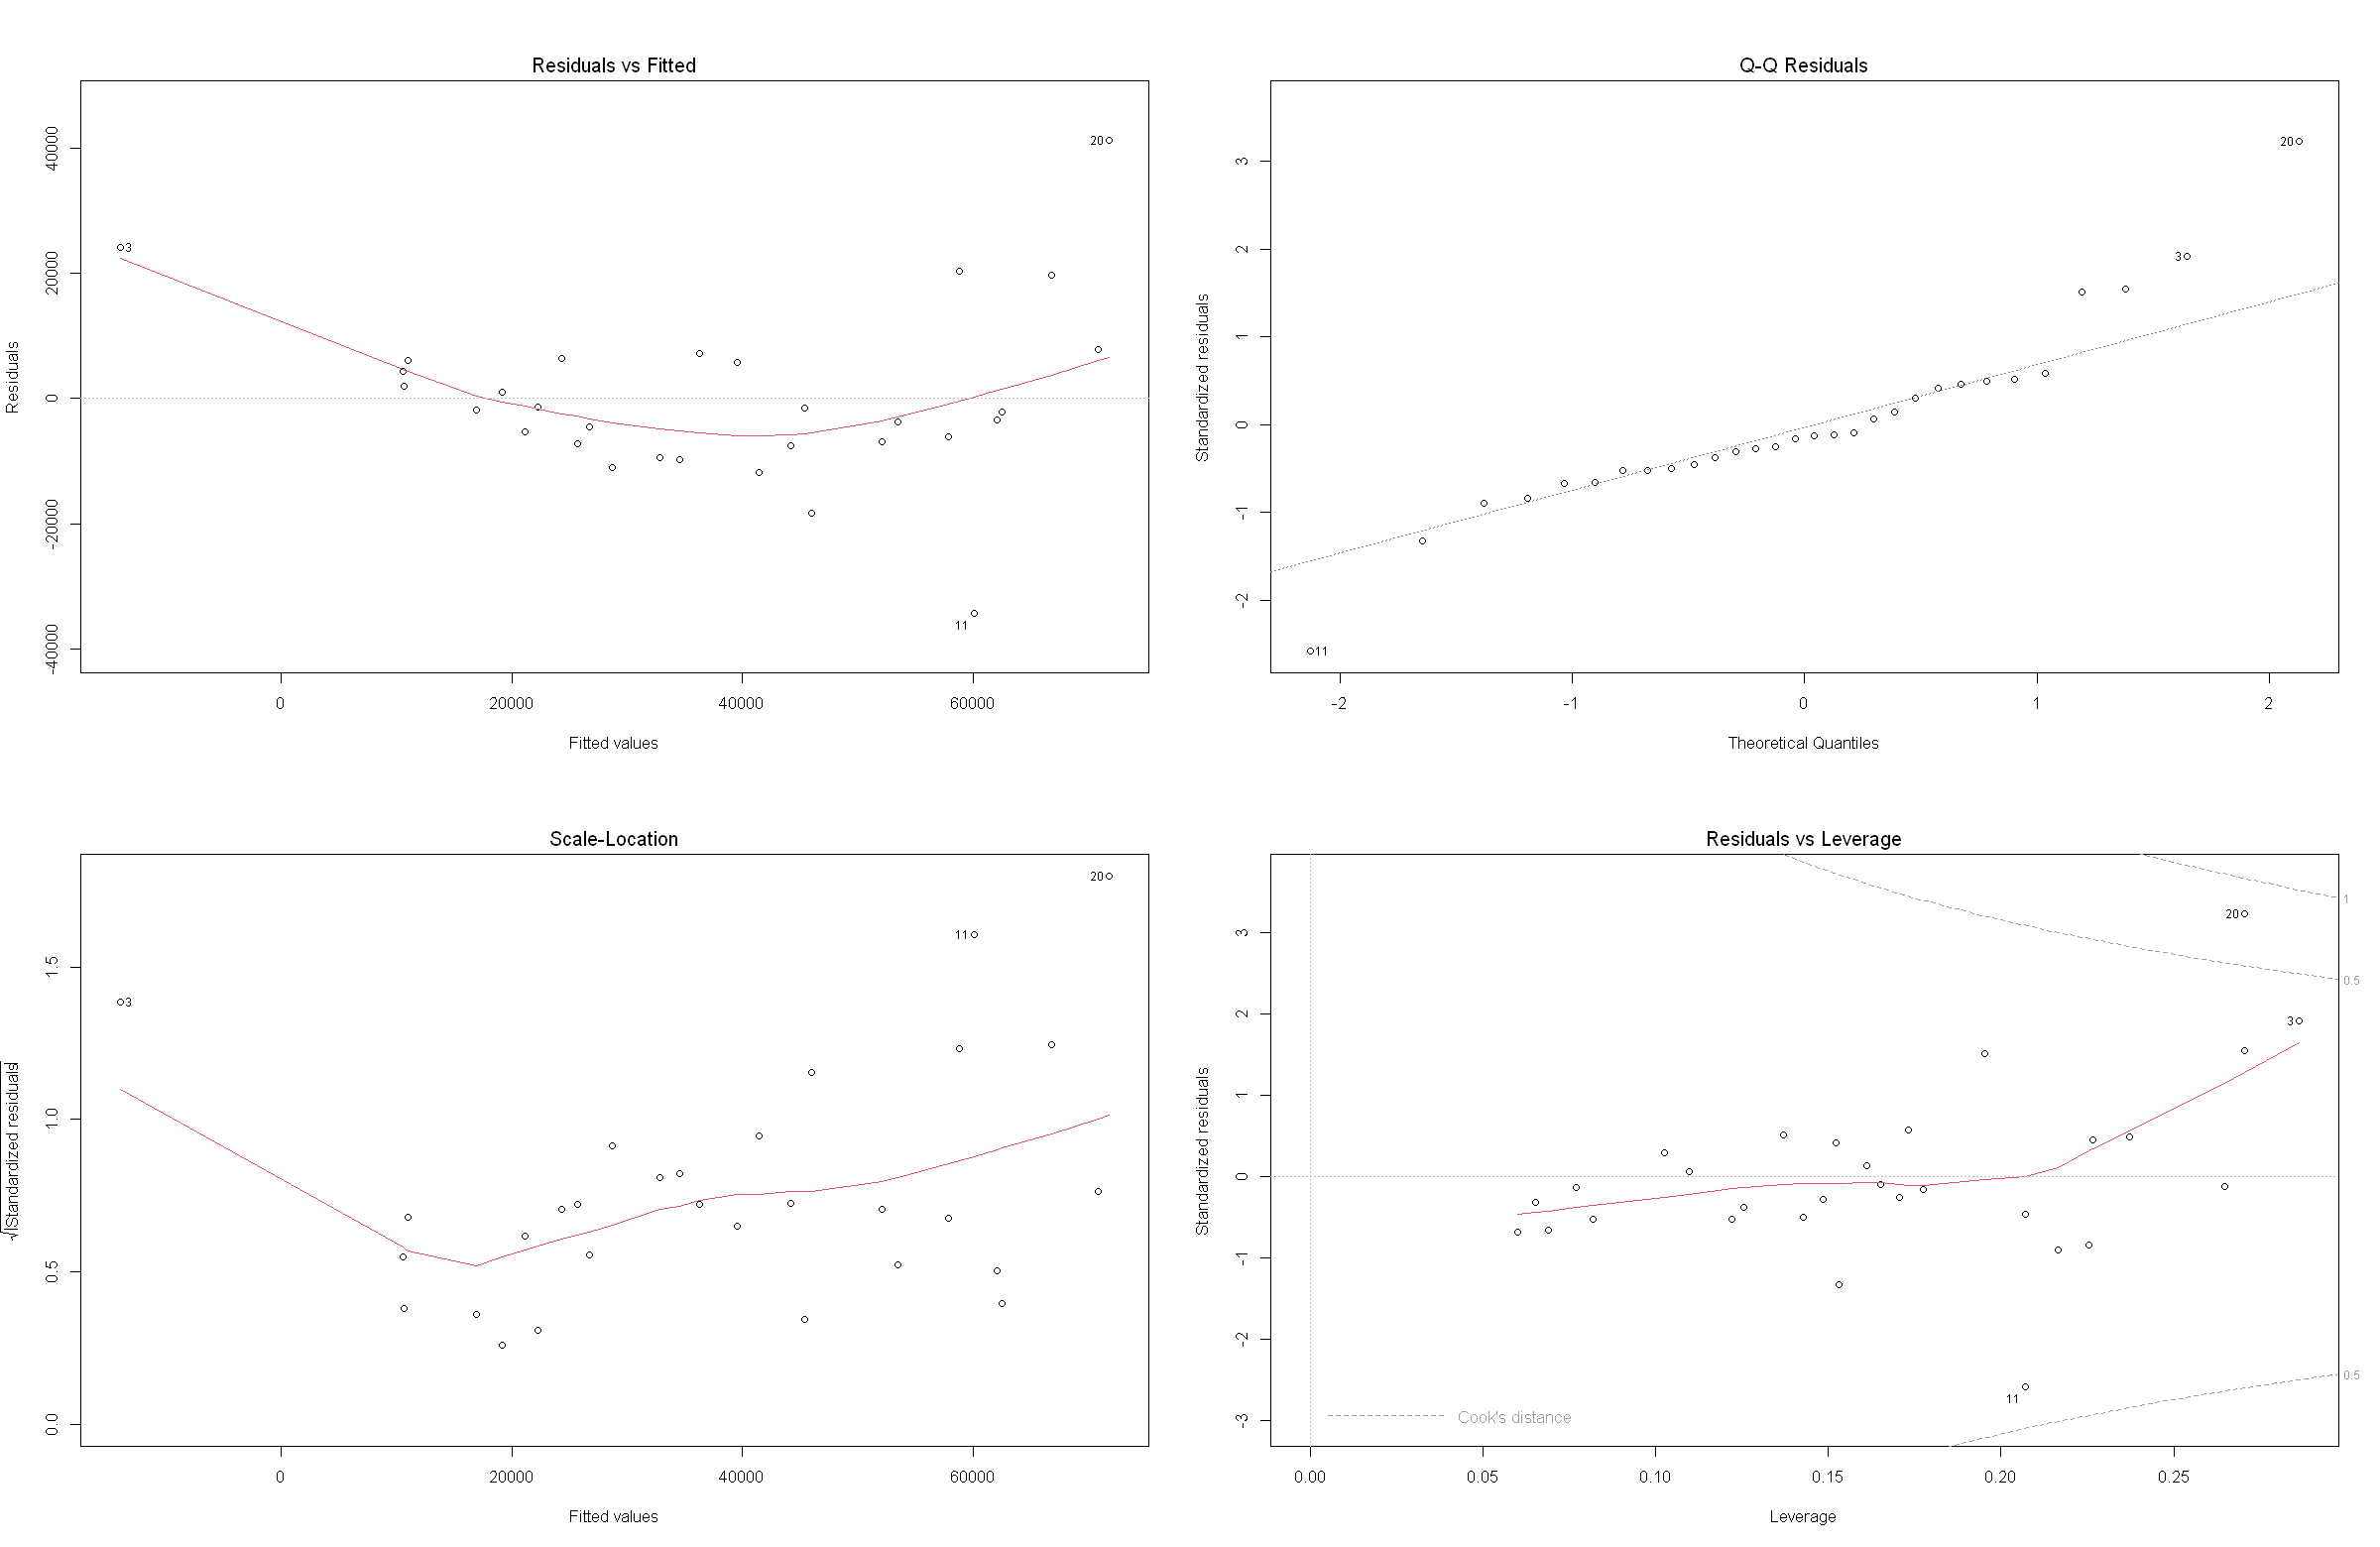

In [265]:
par(mfrow=c(2,2))
plot(preFinal)

Je zřejmé, že některá pozorování jsou odlehlá, zkusíme tedy aplikovat model robustní regrese se specifikovanou Huberovou funkcí. 

In [266]:
final_rlm = rlm(gdp ~ internet_usage + system + life_expectancy + sectors_expenditure, data = df, psi = psi.huber)
summary(final_rlm)

Warning message in rlm.default(x, y, weights, method = method, wt.method = wt.method, :
"'rlm' failed to converge in 20 steps"



Call: rlm(formula = gdp ~ internet_usage + system + life_expectancy + 
    sectors_expenditure, data = df, psi = psi.huber)
Residuals:
   Min     1Q Median     3Q    Max 
-28797  -5298  -1193   4599  50170 

Coefficients:
                    Value        Std. Error   t value     
(Intercept)         -302588.6648   49735.8961      -6.0839
internet_usage         1890.7608     375.1255       5.0403
system                -5059.2871    4922.5848      -1.0278
life_expectancy        2174.7766     630.7123       3.4481
sectors_expenditure   -1075.1890    2414.2988      -0.4453

Residual standard error: 7650 on 25 degrees of freedom

Pro ověření ještě zjistíme signifikanci jednotlivých regresorů. S využitím Robustního f testu. Položíme:<br>
**H0:** Regresor je roven 0. <br />
**HA:** Regresor není roven 0.

In [267]:
f.robftest(final_rlm, var = "internet_usage")


	robust F-test (as if non-random weights)

data:  from rlm(formula = gdp ~ internet_usage + system + life_expectancy + from     sectors_expenditure, data = df, psi = psi.huber)
F = 22.932, p-value = 6.443e-05
alternative hypothesis: true internet_usage is not equal to 0


Na základě p-hodnoty se přikláníme k alternativě.<br>
To znamená, že regresor ponecháme.

In [268]:
f.robftest(final_rlm, var = "system")


	robust F-test (as if non-random weights)

data:  from rlm(formula = gdp ~ internet_usage + system + life_expectancy + from     sectors_expenditure, data = df, psi = psi.huber)
F = 0.92089, p-value = 0.3464
alternative hypothesis: true system is not equal to 0


Na základě p-hodnoty nezamítáme nulovou hypotézu.<br>
Regresor tedy vynecháme.

In [269]:
f.robftest(final_rlm, var = "life_expectancy")


	robust F-test (as if non-random weights)

data:  from rlm(formula = gdp ~ internet_usage + system + life_expectancy + from     sectors_expenditure, data = df, psi = psi.huber)
F = 12.032, p-value = 0.00191
alternative hypothesis: true life_expectancy is not equal to 0


Na základě p-hodnoty se přikláníme k alternativě.<br>
To znamená, že regresor ponecháme.

In [270]:
f.robftest(final_rlm, var = "sectors_expenditure")


	robust F-test (as if non-random weights)

data:  from rlm(formula = gdp ~ internet_usage + system + life_expectancy + from     sectors_expenditure, data = df, psi = psi.huber)
F = 0.1594, p-value = 0.6931
alternative hypothesis: true sectors_expenditure is not equal to 0


Na základě p-hodnoty nezamítáme nulovou hypotézu.<br>
Regresor tedy vynecháme.

#### Výběr finálního modelu

Hledáme ideální, který HDP dobře popisuje a zároveň neobsahuje nepotřebné komponenty.<br>
Využijeme sekvenční výběr.

In [271]:
final <- step(lm(gdp~1,data=df), scope=list(lower=~1,upper=~internet_usage * life_expectancy * system * sectors_expenditure), data=df)

Start:  AIC=609.23
gdp ~ 1

                      Df  Sum of Sq        RSS    AIC
+ internet_usage       1 1.1471e+10 7.0483e+09 582.25
+ life_expectancy      1 8.0283e+09 1.0491e+10 594.18
+ system               1 4.4934e+09 1.4026e+10 602.89
+ sectors_expenditure  1 2.5322e+09 1.5987e+10 606.82
<none>                              1.8520e+10 609.23

Step:  AIC=582.25
gdp ~ internet_usage

                      Df  Sum of Sq        RSS    AIC
+ life_expectancy      1 1.1009e+09 5.9473e+09 579.15
<none>                              7.0483e+09 582.25
+ system               1 2.2187e+08 6.8264e+09 583.29
+ sectors_expenditure  1 2.7231e+07 7.0210e+09 584.13
- internet_usage       1 1.1471e+10 1.8520e+10 609.23

Step:  AIC=579.15
gdp ~ internet_usage + life_expectancy

                                 Df  Sum of Sq        RSS    AIC
+ internet_usage:life_expectancy  1 1371575542 4.5758e+09 573.29
<none>                                         5.9473e+09 579.15
+ sectors_expenditure        

In [272]:
summary(final)


Call:
lm(formula = gdp ~ internet_usage + life_expectancy + sectors_expenditure + 
    internet_usage:life_expectancy + internet_usage:sectors_expenditure, 
    data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-36689  -3641    350   4071  31461 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)                        2485906.7   844751.9   2.943  0.00711 **
internet_usage                      -30123.8     9620.2  -3.131  0.00453 **
life_expectancy                     -35456.1    11402.3  -3.110  0.00478 **
sectors_expenditure                 110701.9    71353.3   1.551  0.13388   
internet_usage:life_expectancy         430.4      128.8   3.340  0.00273 **
internet_usage:sectors_expenditure   -1235.8      762.3  -1.621  0.11805   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12550 on 24 degrees of freedom
Multiple R-squared:  0.7958,	Adjusted R-squared:  0.7533 
F-statistic: 1

Na základě p-hodnoty testu o nenulovosti vyřadíme sectors_expenditure.

In [273]:
final <- step(lm(gdp~1,data=df), scope=list(lower=~1,upper=~internet_usage * life_expectancy * system),data=df, direction="both")

Start:  AIC=609.23
gdp ~ 1

                  Df  Sum of Sq        RSS    AIC
+ internet_usage   1 1.1471e+10 7.0483e+09 582.25
+ life_expectancy  1 8.0283e+09 1.0491e+10 594.18
+ system           1 4.4934e+09 1.4026e+10 602.89
<none>                          1.8520e+10 609.23

Step:  AIC=582.25
gdp ~ internet_usage

                  Df  Sum of Sq        RSS    AIC
+ life_expectancy  1 1.1009e+09 5.9473e+09 579.15
<none>                          7.0483e+09 582.25
+ system           1 2.2187e+08 6.8264e+09 583.29
- internet_usage   1 1.1471e+10 1.8520e+10 609.23

Step:  AIC=579.15
gdp ~ internet_usage + life_expectancy

                                 Df  Sum of Sq        RSS    AIC
+ internet_usage:life_expectancy  1 1371575542 4.5758e+09 573.29
<none>                                         5.9473e+09 579.15
+ system                          1   87696918 5.8596e+09 580.70
- life_expectancy                 1 1100921818 7.0483e+09 582.25
- internet_usage                  1 4543920218 

In [274]:
summary(final)


Call:
lm(formula = gdp ~ internet_usage + life_expectancy + internet_usage:life_expectancy, 
    data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-29875  -4036   -721   3653  45161 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                    1655793.7   714444.5   2.318   0.0286 * 
internet_usage                  -20518.3     8202.3  -2.502   0.0190 * 
life_expectancy                 -22806.3     8922.3  -2.556   0.0168 * 
internet_usage:life_expectancy     284.6      102.0   2.792   0.0097 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13270 on 26 degrees of freedom
Multiple R-squared:  0.7529,	Adjusted R-squared:  0.7244 
F-statistic: 26.41 on 3 and 26 DF,  p-value: 4.697e-08


Finální model užívá internet_usage a life_expectancy a jejich interakci.<br>
To se zároveň shoduje s poznatky předchozí robustní analýzy.